In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import csv
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
def process_event(data, output_folder, event, view, image_size):
    nv_coords = 2
    nh_coords = 6 

    try:
        x_vtx, z_vtx = float(data[0]), float(data[1]) 
        evt_drift_min, evt_drift_max = float(data[2]), float(data[3])  
        evt_wire_min, evt_wire_max = float(data[4]), float(data[5])  
        intr_drift_min, intr_drift_max = float(data[6]), float(data[7])
        intr_wire_min, intr_wire_max = float(data[8]), float(data[9])
        n_hits = int(data[10])  
        mu_px, mu_py, mu_pz = float(data[11]), float(data[12]), float(data[13])
        piplus_px, piplus_py, piplus_pz = float(data[14]), float(data[15]), float(data[16])
        piminus_px, piminus_py, piminus_pz = float(data[17]), float(data[18]), float(data[19])
    except ValueError as e:
        print(f"Error parsing event metadata: {e}")
        return

    #print(f"Event {event}:")
    #print(f"  x_vtx={x_vtx}, z_vtx={z_vtx}, evt_drift_min={evt_drift_min}, evt_drift_max={evt_drift_max}, evt_wire_min={evt_wire_min}, evt_wire_max={evt_wire_max}")
    #print(f"  Interaction drift_min={intr_drift_min}, drift_max={intr_drift_max}, wire_min={intr_wire_min}, wire_max={intr_wire_max}")
    #print(f"  Number of hits: {n_hits}")
    #print(f"  Particle momentum:")
    #print(f"    mu_px={mu_px}, mu_py={mu_py}, mu_pz={mu_pz}")
    #print(f"    piplus_px={piplus_px}, piplus_py={piplus_py}, piplus_pz={piplus_pz}")
    #print(f"    piminus_px={piminus_px}, piminus_py={piminus_py}, piminus_pz={piminus_pz}")

    hit_data = data[20:]

    if len(hit_data) < n_hits * nh_coords:
        print(f"  Warning: Inconsistent hit data length for event {event}")
        return

    hit_x = np.array(hit_data[0::nh_coords], dtype=float)
    hit_z = np.array(hit_data[1::nh_coords], dtype=float)
    hit_adc = np.array(hit_data[2::nh_coords], dtype=float)  
    hit_muon_flag = np.array(hit_data[3::nh_coords], dtype=float) 
    hit_piplus_flag = np.array(hit_data[4::nh_coords], dtype=float)  
    hit_piminus_flag = np.array(hit_data[5::nh_coords], dtype=float)

    if len(hit_muon_flag) != len(hit_piplus_flag) or len(hit_muon_flag) != len(hit_piminus_flag) or len(hit_muon_flag) != len(hit_x):
        print(f"  Warning: Inconsistent flag data lengths for event {event} - skipping this event.")
        return

    #print(f"  Hit x position range: {hit_x.min()} to {hit_x.max()}")
    #print(f"  Hit z position range: {hit_z.min()} to {hit_z.max()}")

    if len(hit_x) == 0 or len(hit_z) == 0 or len(hit_adc) == 0:
        print(f"  Warning: No hit data for event {event}.")
        return

    non_default_hits = np.where((hit_muon_flag != 0) | (hit_piplus_flag != 0) | (hit_piminus_flag != 0))[0]
    if len(non_default_hits) > 0:
        print(f"  Non-default hit flags at indices: {non_default_hits}")
        print(f"  Corresponding hit flags: {hit_muon_flag[non_default_hits]}, {hit_piplus_flag[non_default_hits]}, {hit_piminus_flag[non_default_hits]}")

    hit_flags = np.vstack((hit_muon_flag, hit_piplus_flag, hit_piminus_flag)).T

    input_histogram, truth_histogram = make_input_and_truth_histogram(
        hit_x, hit_z, hit_adc, hit_flags, 
        (intr_drift_min, intr_drift_max), (intr_wire_min, intr_wire_max), 
        image_size, view
    )

    hits_output_folder = os.path.join(output_folder, "Hits")
    truth_output_folder = os.path.join(output_folder, "Truth")

    #print(f"Event {event}: Max value of input histogram: {np.max(input_histogram)}")
    #print(f"Event {event}: Unique values in truth histogram: {np.unique(truth_histogram)}")
    
    hits_filename = os.path.join(hits_output_folder, f"Image_{event}.npz")
    truth_filename = os.path.join(truth_output_folder, f"Image_{event}.npz")
    
    #print(f"Saving hits histogram to {hits_filename}")
    #print(f"Saving truth histogram to {truth_filename}")

    np.savez_compressed(hits_filename, input_histogram)
    np.savez_compressed(truth_filename, truth_histogram)



def make_input_and_truth_histogram(x, z, adc, flags, x_bounds, z_bounds, image_size, view):
    image_height, image_width = image_size
    x_min, x_max = x_bounds
    z_min, z_max = z_bounds

    if x_min >= x_max or z_min >= z_max:
        raise ValueError(f"Bounds error: x_bounds ({x_min}, {x_max}) or z_bounds ({z_min}, {z_max}) are not valid.")

    z_bins = np.linspace(z_min - 0.5 * wire_pitch[view], z_max + 0.5 * wire_pitch[view], image_height + 1)
    x_bins = np.linspace(x_min - 0.5 * drift_step, x_max + 0.5 * drift_step, image_width + 1)

    if not (np.all(np.diff(z_bins) > 0) and np.all(np.diff(x_bins) > 0)):
        raise ValueError(f"Bin array error: z_bins or x_bins are not monotonically increasing.")

    input_histogram, _, _ = np.histogram2d(z, x, bins=[z_bins, x_bins], weights=adc)
    input_histogram = input_histogram.astype(float)

    #truth_histogram = np.full_like(input_histogram, np.nan, dtype='float')
    truth_histogram = np.zeros_like(input_histogram, dtype='float')
    
    for i in range(len(x)):
        x_idx = np.clip(np.digitize(x[i], x_bins) - 1, 0, image_width - 1)
        z_idx = np.clip(np.digitize(z[i], z_bins) - 1, 0, image_height - 1)

        if np.array_equal(flags[i], [1.0, 0.0, 0.0]):
            cls = 1  # Muon
        elif np.array_equal(flags[i], [0.0, 1.0, 0.0]):
            cls = 2  # Pion-plus
        elif np.array_equal(flags[i], [0.0, 0.0, 1.0]):
            cls = 3  # Pion-minus
        else:
            cls = 0  # Background

        truth_histogram[z_idx, x_idx] = cls

    #print(f"  Input histogram shape: {input_histogram.shape}, max value: {np.max(input_histogram)}")
    #print(f"  Truth histogram shape: {truth_histogram.shape}, unique values: {np.unique(truth_histogram[~np.isnan(truth_histogram)])}")

    return input_histogram, truth_histogram

def process_file(input_file, output_folder, view, image_size=(128, 128)):
    with open(input_file, 'r') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            data = row[1:-1] 
            process_event(data, output_folder, i, view, image_size)


In [3]:
wire_pitch = { "U": 0.3, "V": 0.3, "W": 0.3 }
drift_step = 0.5

file_prefix = "training_output_"  
image_size = (256, 256) 

for view in ["W", "U", "V"]:
    global_path = os.path.join(f"Images_{view}")
    os.makedirs(global_path, exist_ok=True)

    for folder in ["Hits", "Truth"]:
        os.makedirs(os.path.join(global_path, folder), exist_ok=True)

    process_file(file_prefix + view + ".csv", global_path, view, image_size=image_size)

Event 0:
  x_vtx=116.504, z_vtx=899.475, evt_drift_min=-43.9245, evt_drift_max=307.358, evt_wire_min=0.55, evt_wire_max=1036.45
  Interaction drift_min=38.917, drift_max=254.883, wire_min=798.25, wire_max=1034.35
  Number of hits: 6615
  Particle momentum:
    mu_px=0.268268, mu_py=0.208096, mu_pz=0.202334
    piplus_px=-0.0305821, piplus_py=-0.20841, piplus_pz=0.244678
    piminus_px=0.049907, piminus_py=0.0224928, piminus_pz=-0.122597
  Hit x position range: -43.9245 to 307.358
  Hit z position range: 0.55 to 1036.45
  Non-default hit flags at indices: [4979 4980 4986 4987 4992 4998 5005 5006 5007 5010 5013 5016 5020 5021
 5025 5029 5030 5034 5037 5038 5039 5042 5046 5047 5048 5051 5055 5056
 5059 5062 5065 5070 5071 5074 5079 5080 5082 5087 5088 5090 5094 5095
 5097 5100 5103 5105 5109 5112 5113 5116 5120 5121 5123 5125 5126 5129
 5131 5132 5134 5139 5141 5144 5147 5149 5150 5151 5152 5153 5154 5155
 5159 5160 5161 5162 5163 5168 5173 5203 5208 5218 5224 5229 5236 5242
 5248 5254 52

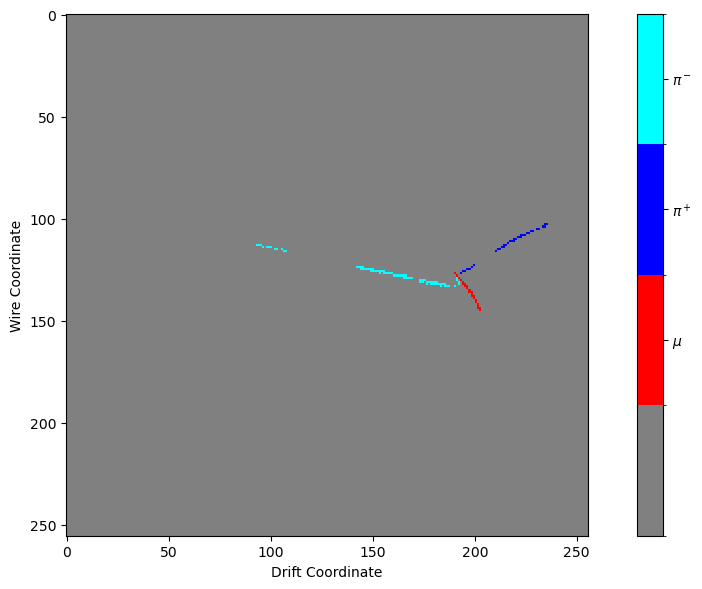

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

def visualize_truth_histogram(truth_histogram, title=""):
    cmap = ListedColormap(['grey', 'red', 'blue', 'cyan'])  # Grey (background), Blue (muon), Red (pion-plus), Purple (pion-minus)
    
    bounds = [0, 1, 2, 3, 4]
    norm = BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10, 6))
    masked_truth_histogram = np.ma.masked_invalid(truth_histogram)
    plt.imshow(masked_truth_histogram, cmap=cmap, norm=norm, aspect='equal', interpolation='none')

    cbar = plt.colorbar(ticks=[1.5, 2.5, 3.5]) 
    cbar.ax.set_yticklabels([r'$\mu$', r'$\pi^+$', r'$\pi^-$'])  

    plt.xlabel("Drift Coordinate")
    plt.ylabel("Wire Coordinate")

    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

with open("/gluster/home/cthorpe/DeepLearning/Images_U/Truth/Image_21.npz", 'rb') as file:
    truth_data = np.load(file)
    truth_histogram = truth_data['arr_0']

visualize_truth_histogram(truth_histogram, title="")

Loaded histogram shape: (256, 256)
Max value in the loaded histogram: 483305.0


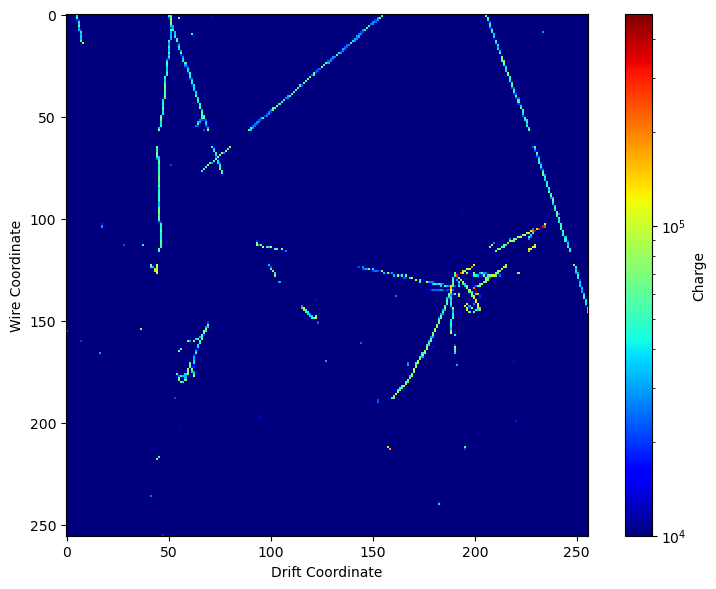

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

with open("/gluster/home/cthorpe/DeepLearning/Images_U/Hits/Image_21.npz", 'rb') as file:
    data = np.load(file)
    input_histogram = data['arr_0']
    print(f"Loaded histogram shape: {input_histogram.shape}")
    print(f"Max value in the loaded histogram: {np.max(input_histogram)}")

threshold = 1e4  
input_histogram[input_histogram < threshold] = threshold 

plt.figure(figsize=(8, 6))
plt.imshow(input_histogram, cmap='jet', norm=LogNorm(vmin=threshold), aspect='equal', interpolation='none')

cbar = plt.colorbar()
cbar.set_label("Charge")

plt.title("")
plt.xlabel("Drift Coordinate")
plt.ylabel("Wire Coordinate")

plt.tight_layout()  
plt.show()
